# Overview {#sec-opensim}

In this script, we will use the OpenSim (@seth_etal18) to model the inverse kinematics (i.e., joint angles) and dynamics (i.e., joint forces) of the motion tracking data. 

The documentation of OpenSim project is available [here](https://opensimconfluence.atlassian.net/wiki/spaces/OpenSim/overview)

In [ ]:
#| code-fold: true
#| code-summary: Code to prepare the environment

import opensim
import os
import glob
import shutil
import pandas as pd
from scipy.signal import savgol_filter
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt

curfolder = os.getcwd()

# This is where we store the data
projectdata = os.path.join(curfolder, 'projectdata')
# These are the sessions we want to track
sessionstotrack = glob.glob(os.path.join(projectdata, 'Session*'))
print(sessionstotrack)

# Here we store the metadata about weight, height
META = pd.read_csv(curfolder + '\\..\\00_RAWDATA\META_mass.txt', sep='\t')

# Here are the config files for the OpenSim pipeline
scalefile = curfolder + '/Pose2Sim/OpenSim_Setup/Scaling_Setup_Pose2Sim_Body135_FLESH.xml'
ikfile = curfolder + '/Pose2Sim/OpenSim_Setup/IK_Setup_Pose2Sim_Body135_FLESH.xml'
idfile = curfolder + '/Pose2Sim/OpenSim_Setup/ID_Setup_Pose2Sim_Body135_FLESH.xml'

# Get sessionIDs
sessionIDs = []
for session in sessionstotrack:
    sessionIDs.append(session.split('\\')[-1])
    sessionIDs[-1] = sessionIDs[-1].split('_')[1]
    # Keep only unique values
    sessionIDs = list(set(sessionIDs))

print(sessionIDs)


In [ ]:
#| code-fold: true
#| code-summary: Custom functions

# Function to update XML file
def update_xml_file(dir, input_file, output_file, new_mass=None, new_model_file=None, new_marker_file=None, new_timerange=None, new_output_model_file=None, new_coord_file=None):

    # Load the XML document
    tree = ET.parse(input_file)
    root = tree.getroot()

    # If the file has Scaling in the name, we need to update the marker file
    if 'Scaling' in input_file:
        
        # Update the <mass> element if a new value is provided
        if new_mass is not None:
            mass_element = root.find('.//mass')
            if mass_element is not None:
                mass_element.text = new_mass

        # Update the <model_file> element within <GenericModelMaker> if a new value is provided
        if new_model_file is not None:
            model_file_element = root.find('.//GenericModelMaker/model_file')
            if model_file_element is not None:
                model_file_element.text = new_model_file

        # Update the <marker_file> element within <ModelScaler> and <MarkerPlacer> if a new value is provided
        if new_marker_file is not None:
            marker_file_elements = root.findall('.//marker_file')
            for marker_file_element in marker_file_elements:
                marker_file_element.text = new_marker_file

        # Update all time ranges
        if new_timerange is not None:
            timerange_elements = root.findall('.//time_range')
            for timerange_element in timerange_elements:
                timerange_element.text = new_timerange

        # Update the <output_model_file> element within <MarkerPlacer> if a new value is provided
        if new_output_model_file is not None:
            output_model_file_element = root.find('.//MarkerPlacer/output_model_file')
            if output_model_file_element is not None:
                output_model_file_element.text = new_output_model_file

        # Update the <output_model_file> element within <ModelScaler> if a new value is provided
        if new_output_model_file is not None:
            output_model_file_element = root.find('.//ModelScaler/output_model_file')
            if output_model_file_element is not None:
                output_model_file_element.text = new_output_model_file
    
    elif 'IK' in input_file:
        # We update model_file
        if new_model_file is not None:
            model_file_element = root.find('.//model_file')
            if model_file_element is not None:
                model_file_element.text = new_model_file

        # We need to update time range
        if new_timerange is not None:
            timerange_elements = root.findall('.//time_range')
            for timerange_element in timerange_elements:
                timerange_element.text = new_timerange

        # And we need to update the path to trc file
        if new_marker_file is not None:
            marker_file_element = root.find('.//marker_file')
            if marker_file_element is not None:
                marker_file_element.text = new_marker_file

        # And output_motion_file
        if new_output_model_file is not None:
            output_model_file_element = root.find('.//output_motion_file')
            if output_model_file_element is not None:
                output_model_file_element.text = new_output_model_file

    elif 'ID' in input_file:
        # We update model_file
        if new_model_file is not None:
            model_file_element = root.find('.//model_file')
            if model_file_element is not None:
                model_file_element.text = new_model_file

        # We need to update time range
        if new_timerange is not None:
            timerange_elements = root.findall('.//time_range')
            for timerange_element in timerange_elements:
                timerange_element.text = new_timerange

        # And we need to update the path to mot file
        if new_coord_file is not None:
            coord_file_element = root.find('.//coordinates_file')
            if coord_file_element is not None:
                coord_file_element.text = new_coord_file

        # And output_motion_file
        if new_output_model_file is not None:
            output_model_file_element = root.find('.//output_gen_force_file')
            if output_model_file_element is not None:
                output_model_file_element.text = new_output_model_file

    if 'Scaling' in input_file:
        output_file_path = os.path.join(dir, output_file) # Scaling is saved in the participant folder
        tree.write(output_file_path, encoding='UTF-8', xml_declaration=True)
    else:
        tree.write(output_file, encoding='UTF-8', xml_declaration=True)

# Function to extract time range from a trial
def extract_first_and_last_time(file_path):

    df = pd.read_csv(file_path, sep='\t', skiprows=4)
    # Extract the first and last time values, time is the second column
    first_time = df.iloc[0, 1]
    last_time = df.iloc[-1, 1]
    
    return first_time, last_time

# Function to smooth .mot file
def smooth_data(input_path, output_path, smoothing_params, plot=False, plot_column=None):

    # Read the entire file
    with open(input_path, 'r') as file:
        lines = file.readlines()

    # Identify header and data section
    header_lines = []
    data_start_index = 0

    for i, line in enumerate(lines):
        if line.strip() == 'endheader':
            header_lines = lines[:i + 1]
            data_start_index = i + 1
            break

    # Extract the column headers and numerical data
    column_headers = lines[data_start_index].split()
    data_lines = lines[data_start_index + 1:]
    data = np.array([list(map(float, line.split())) for line in data_lines])

    # Identify the column index for plotting (if applicable)
    plot_column_idx = column_headers.index(plot_column) if plot_column else None

    # Apply smoothing to each column except 'time'
    smoothed_data = data.copy()
    for col_idx in range(1, data.shape[1]):  # Skip 'time' (assumed to be the first column)
        smoothed_data[:, col_idx] = savgol_filter(
            data[:, col_idx], 
            window_length=smoothing_params['window_length'], 
            polyorder=smoothing_params['polyorder']
        )

    if plot == True:
        #Plot unsmoothed vs smoothed data for the specified column
        if plot_column and plot_column_idx is not None:
            plt.figure(figsize=(10, 6))
            plt.plot(data[:, 0], data[:, plot_column_idx], label='Unsmoothed', alpha=0.7)
            plt.plot(data[:, 0], smoothed_data[:, plot_column_idx], label='Smoothed', alpha=0.7)
            plt.xlabel('Time')
            plt.ylabel(plot_column)
            plt.title(f'Unsmoothed vs Smoothed: {plot_column}')
            plt.legend()
            plt.grid(True)
            plt.show()

    # Write back the original structure with smoothed data
    with open(output_path, 'w') as output_file:
        # Write the header
        output_file.writelines(header_lines)
        # Write the column headers
        output_file.write('\t'.join(column_headers) + '\n')
        # Write the smoothed data row by row - this is necessary to maintain the same formatting, otherwise inverse dynamics will fail
        for row in smoothed_data:
            output_file.write('\t'.join(f'{x:.6f}' for x in row) + '\n')
    

The opensim pipeline has three steps
- scaling
- inverse kinematics
- inverse dynamics

In scaling, we scale the model to match the anthropometry of the subject. We use the Pose2sim model with 135 keypoints (BODY_135) and use a pre-recorded t-pose video to scale this model and create new model, scaled for each participant.

In inverse kinematics, we use the scaled model to estimate the joint angles of the participant. We use the motion tracking data to estimate the joint angles. Joint angles are saved as .mot files in /ResultsInverseKinematics folder per each trial.

In inverse dynamics, we use the joint angles to estimate the joint forces. Joint forces are saved as .sto files in /ResultsInverseDynamics folder per each trial.

In [ ]:
#| eval: false

# Note that session contains of two parts that have the same participants (it's always sessionID_1 and sessionID_2)

for sessionID in sessionIDs:
    # Get the session path of the first session
    session1path = os.path.join(projectdata, 'Session_' + sessionID + '_1')
    session2path = os.path.join(projectdata, 'Session_' + sessionID + '_2')
    # Get p0 folders from both sessions
    p0session1 = os.path.join(session1path, 'P0')
    p0session2 = os.path.join(session2path, 'P0')
    # Get p1 folders from both sessions
    p1session1 = os.path.join(session1path, 'P1')
    p1session2 = os.path.join(session2path, 'P1')

    # Merge them
    participants = [p0session1, p0session2, p1session1, p1session2] #p0session1,p0session2
    print(participants)

    for p in participants:
        os.chdir(p)

        ###### SCALING ######
        # We do scaling only for Session x_1 (and copy it to x_2)
        if 'Session_' + sessionID + '_1' in p:
            print(p)

            # Get weight from META for this pcn
            pcn = p.split('\\')[-1].lower()
            weight = META.loc[META['pcn'] == pcn, 'weight'].values[0]
            new_mass = str(weight)

            # Get the path to the input model
            new_model_file = 'opensim\Model_Pose2Sim_Body135.osim'
            new_model_file = os.path.join(p, new_model_file)

            # Get the path to the marker file
            tposefolder = glob.glob(os.path.join(p, '*tpose*'))[0]
            trcfolder = os.path.join(tposefolder, 'pose-3d')
            trcfiles = glob.glob(os.path.join(trcfolder, '*.trc'))
            # Keep only the one with 'butterworth' in its name (this is filtered file)
            new_marker_file = [trc for trc in trcfiles if 'butterworth' in trc][0]
            # Get the time range of this file
            first_time, last_time = extract_first_and_last_time(new_marker_file)
            new_timerange = str(first_time) + ' ' + str(last_time)

            # New output model file
            participant = p.split('\\')[-1]
            new_output_model_file = 'opensim\Model_Pose2Sim_scaled_' + sessionID + '_' + participant + '.osim'

            # Update the XML file with new values
            new_scalefile = 'Scaling_Setup_Pose2Sim_Body135_FLESH_' + sessionID + '_' + participant + '.xml'
            update_xml_file(p, scalefile, new_scalefile, new_mass=new_mass, new_model_file=new_model_file, new_marker_file=new_marker_file, new_timerange=new_timerange, new_output_model_file=new_output_model_file)

            print('Scaling...')
            opensim.ScaleTool(new_scalefile).run()
            
            # Copy scaling setup also to session 2 of the same participant
            session2Path = os.path.join(projectdata, 'Session_' + sessionID + '_2', participant)
            os.makedirs(session2Path, exist_ok=True)
            shutil.copy(new_scalefile, session2Path)
            # And scaled model too
            session2ScaledModelPath = os.path.join(session2Path, 'opensim')
            os.makedirs(session2ScaledModelPath, exist_ok=True)
            shutil.copy(new_output_model_file, session2ScaledModelPath)

        # If its session x_2, we directly go to IK and ID
        else:
            print('Session x_2, skipping scaling...')

        ###### INVERSE KINEMATICS ######

        # Create folder ResultsInverseKinematics
        if not os.path.exists(os.path.join(p, 'ResultsInverseKinematics')):
            os.makedirs(os.path.join(p, 'ResultsInverseKinematics'))
            
        # Collect all folders in p
        folders = glob.glob(os.path.join(p, '*'))

        # Get rid of all folders/files that we don't want now
        folders = [f for f in folders if 'opensim' not in f]
        folders = [f for f in folders if 'toml' not in f]
        folders = [f for f in folders if 'txt' not in f]
        folders = [f for f in folders if 'xml' not in f]
        folders = [f for f in folders if 'sto' not in f]
        folders = [f for f in folders if 'tpose' not in f]
        folders = [f for f in folders if 'ResultsInverseKinematics' not in f]
        folders = [f for f in folders if 'ResultsInverseDynamics' not in f]
        #print(folders)

        for f in folders:
            print(f)
            trialid = f.split('\\')[-1]

            # Get trc file
            trcfiles = glob.glob(os.path.join(f, '*/*.trc'), recursive=True)
            new_trc_file = [trc for trc in trcfiles if 'butterworth' in trc][0]

            # Get the time range from it
            first_time, last_time = extract_first_and_last_time(new_trc_file)
            new_timerange = str(first_time) + ' ' + str(last_time)

            # Get the scaled model
            scaled_model = new_output_model_file
      
            # Output motion file
            output_motion_file = 'ResultsInverseKinematics/' + sessionID + '_' + trialid + '.mot'
            output_motion_file = os.path.join(p, output_motion_file)

            # Update the XML file
            new_ikfile_name = 'IK_Setup_Pose2Sim_Body135_FLESH_' + sessionID + '_' + trialid + '.xml'
            new_ikfile = os.path.join(p, new_ikfile_name)
            update_xml_file(p, ikfile, new_ikfile, new_model_file=scaled_model, new_marker_file=new_trc_file, new_timerange=new_timerange, new_output_model_file=output_motion_file)

            print('Inverse Kinematics...')
            try:
                opensim.InverseKinematicsTool(new_ikfile).run()
            except:
                print('Error in IK')
                continue

            # opensim doesn't smooth the data, but we need to smooth them before inverse dynamics, otherwise we will magnify the noise
            smoothing_params = {'window_length': 35, 'polyorder': 3}
            smooth_data(output_motion_file, output_motion_file, smoothing_params, plot=True, plot_column='arm_flex_r')

            ###### INVERSE DYNAMICS ######

            # Create folder ResultsInverseKinematics
            if not os.path.exists(os.path.join(p, 'ResultsInverseDynamics')):
                os.makedirs(os.path.join(p, 'ResultsInverseDynamics'))

            # Time range is the same as in IK
            # Scaled model is the same
            # mot file is the new_ikfile
            # Output force file
            output_gen_force_file = 'ResultsInverseDynamics/' + sessionID + '_' + trialid + '_ID.sto'
            output_gen_force_file = os.path.join(p, output_gen_force_file)

            # Update the XML file
            new_idfile_name = 'ID_Setup_Pose2Sim_Body135_FLESH_' + sessionID + '_' + trialid + '.xml'
            new_idfile = os.path.join(p, new_idfile_name)
            update_xml_file(p, idfile, new_idfile, new_model_file=scaled_model, new_timerange=new_timerange, new_coord_file=output_motion_file, new_output_model_file=output_gen_force_file)

            print('Inverse Dynamics...')
            try:
                opensim.InverseDynamicsTool(new_idfile).run()
            except:
                print('Error in ID')
                continue


All error information is in the opensim.log file in the */Session_x/Participant* folder

Here is an example of angle (full line) and moment/torque (dashed) data for right hip. They are further processed in @sec-procmot.

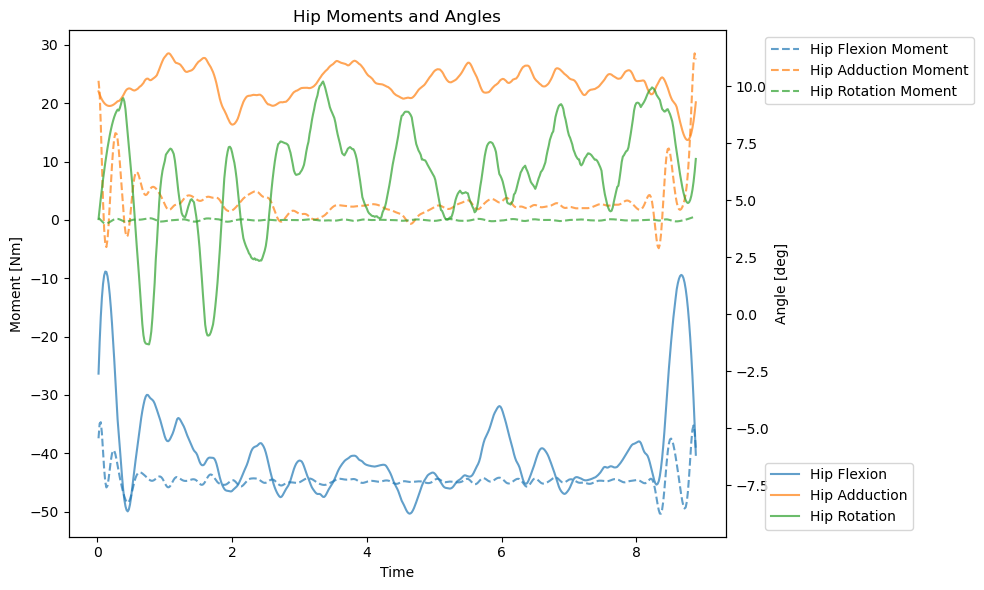

In [18]:
#| echo: false

idfolder = glob.glob(curfolder + '\\projectdata\\*\\*\\ResultsInverseDynamics\\', recursive=True)
ikfolder = glob.glob(curfolder + '\\projectdata\\*\\*\\ResultsInverseKinematics\\', recursive=True)

# Pick one folder and one file
idfile = glob.glob(idfolder[0] + '*.sto')[1]
ikfile = glob.glob(ikfolder[0] + '*.mot')[1]

# Load in
iddata = pd.read_csv(idfile, sep='\t', skiprows=6)
ikdata = pd.read_csv(ikfile, sep='\t', skiprows=10)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create second y-axis
ax2 = ax1.twinx()

# Define colors for consistency
colors = {
    'Hip Flexion': 'tab:blue',
    'Hip Adduction': 'tab:orange',
    'Hip Rotation': 'tab:green'
}

# Plot moments (dashed lines) on primary y-axis
ax1.plot(iddata['time'], iddata['hip_flexion_r_moment'], label='Hip Flexion Moment', linestyle='--', color=colors['Hip Flexion'], alpha=0.7)
ax1.plot(iddata['time'], iddata['hip_adduction_r_moment'], label='Hip Adduction Moment', linestyle='--', color=colors['Hip Adduction'], alpha=0.7)
ax1.plot(iddata['time'], iddata['hip_rotation_r_moment'], label='Hip Rotation Moment', linestyle='--', color=colors['Hip Rotation'], alpha=0.7)

# Plot angles (solid lines) on secondary y-axis
ax2.plot(ikdata['time'], ikdata['hip_flexion_r'], label='Hip Flexion', linestyle='-', color=colors['Hip Flexion'], alpha=0.7)
ax2.plot(ikdata['time'], ikdata['hip_adduction_r'], label='Hip Adduction', linestyle='-', color=colors['Hip Adduction'], alpha=0.7)
ax2.plot(ikdata['time'], ikdata['hip_rotation_r'], label='Hip Rotation', linestyle='-', color=colors['Hip Rotation'], alpha=0.7)

# Labels
ax1.set_xlabel('Time')
ax1.set_ylabel('Moment [Nm]', color='black')
ax2.set_ylabel('Angle [deg]', color='black')

# Title
plt.title('Hip Moments and Angles')

# Legends
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Adjust legend position
ax2.legend(loc='lower left', bbox_to_anchor=(1.05, 0))

# Improve layout
fig.tight_layout()

# Show plot
plt.show()
